# Classifying CMU Face Images

# Load libraries

In [1]:
import random
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split

# Check for MPS (Apple Silicon), CUDA (for Nvidia GPUs), or fallback to CPU

We're checking for different device options (MPS, CUDA, or CPU) to ensure that our PyTorch model runs on the most powerful hardware available. Running on a GPU (like CUDA or MPS) significantly speeds up computations, especially for tasks involving large datasets or deep learning models, by performing parallel processing. If no GPU is available, the code falls back to using the CPU, which is slower but still functional.

On Mac, newer Apple Silicon chips (M1/M2) support GPU acceleration through Metal Performance Shaders (MPS), which we check for to optimize performance.

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Metal Performance Shaders for Mac
elif torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA for Nvidia GPUs (if available on Mac)
else:
    device = torch.device('cpu')   # Fallback to CPU

print(f'Using device: {device}')

Using device: mps


# Loading/Exploring our data

We should resize the images to be 32x32 because the original LeNet-5 architecture expects input images of size 32x32, as it was originally designed for the MNIST dataset, where images have that specific resolution.

In [4]:
# Dataset transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

In [5]:
# Load dataset
data = ImageFolder(root='../../data/emotions', transform=transform)

In [6]:
print(f"There are {len(data.classes)} classes.")
print(data.classes)

There are 4 classes.
['angry', 'happy', 'neutral', 'sad']


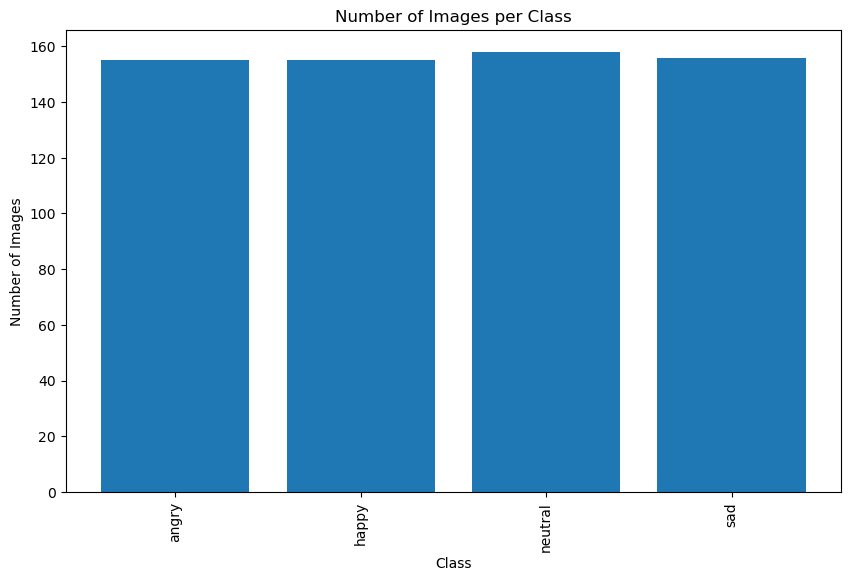

In [7]:
# Get all the labels (targets) from the dataset
labels = [label for _, label in data]

# Count the occurrences of each label
label_counts = Counter(labels)

# Get the class names and the corresponding counts
class_names = data.classes
counts = [label_counts[i] for i in range(len(class_names))]

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [8]:
def visualize_random_images(dataset, num_images=5):
    """
    Visualizes a specified number of random images from the dataset and shows their labels.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    indices = random.sample(range(len(dataset)), num_images)
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        image = image.numpy().transpose((1, 2, 0))
        image = image * 0.5 + 0.5  # Unnormalize the image

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')

    plt.show()

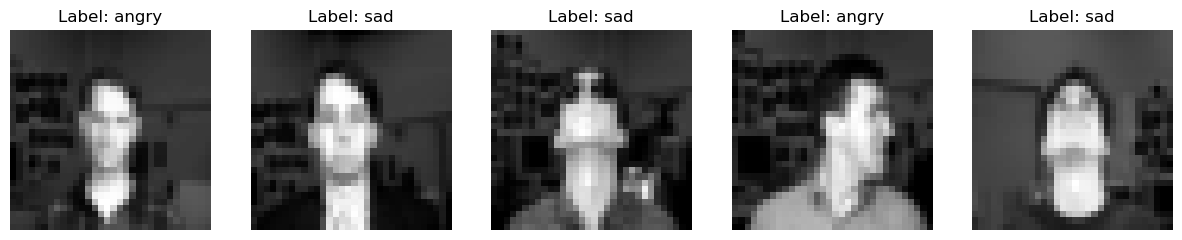

In [9]:
visualize_random_images(data)

# Train/Test/Val

In [10]:
train_size = int(0.6 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size

train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

print(f"Training set: {len(train_data)}, Validation set: {len(val_data)}, Testing set: {len(test_data)}")

Training set: 374, Validation set: 124, Testing set: 126


In [11]:
# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [12]:
print(f'Number of batches per epoch: {len(train_loader)}')

Number of batches per epoch: 6


# Define the LeNet-5 architecture

We switched the original 10 output features to 20 in the final fully connected layer because the number of output neurons must match the number of classes in your dataset. The original model had 10 output neurons, suitable for datasets like MNIST with 10 classes. Since your dataset has 4 classes (sad, neutral, angry, happy), we need 4 output neurons.

In [13]:
# Define the LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Convolutional layer 1: 1 input channel (for grayscale images), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # Subsampling layer (MaxPooling) with 2x2 kernel and stride 2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Subsampling layer (MaxPooling) with 2x2 kernel and stride 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16*5*5, 120)
        # Fully connected layer 2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 84 input features, 4 output features for 4 classes (modified from original LeNet5)
        self.fc3 = nn.Linear(84, 4)

        # Activation function: ReLU will be used
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape of the image is assumed to be [batch_size, 1, 32, 32]

        # Pass the input through the first convolutional layer, then activation, then pool
        x = self.pool1(self.relu(self.conv1(x)))
        # Pass the output through the second convolutional layer, then activation, then pool
        x = self.pool2(self.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pass the flattened output through the first fully connected layer, then activation
        x = self.relu(self.fc1(x))
        # Pass the output through the second fully connected layer, then activation
        x = self.relu(self.fc2(x))
        # Pass the output through the final output layer
        x = self.fc3(x)

        return x

In [14]:
# Instantiate the network
lenet5 = LeNet5().to(device)

In [15]:
# Use CrossEntropyLoss with weights
criterion = nn.CrossEntropyLoss()

In [16]:
# Optimizer (SGD is used in the original paper)
#optimizer = optim.SGD(lenet5.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(lenet5.parameters(), lr=0.001)

# Train the model

In [17]:
%%time
num_epochs = 100 # Number of epochs
early_stop_patience = 10  # Stop training if no improvement for this many epochs
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range( num_epochs):
    lenet5.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Loop through the training batches
    for i, (images, labels) in enumerate(train_loader, 0):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients for proper weight updates

        # Forward pass
        outputs = lenet5(images)
        loss = criterion(outputs, labels)

        # Backward pass 
        loss.backward()

        # Optimize
        optimizer.step()

        running_loss += loss.item()
    
    # Validation step
    lenet5.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = lenet5(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader) # Average validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.6f}, Validation Loss: {val_loss:.6f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print('Early stopping due to no improvement in validation loss.')
        break
    
print('Finished Training')

Epoch [1/100], Training Loss: 1.390270, Validation Loss: 1.387864
Epoch [2/100], Training Loss: 1.384320, Validation Loss: 1.390958
Epoch [3/100], Training Loss: 1.382058, Validation Loss: 1.398819
Epoch [4/100], Training Loss: 1.378243, Validation Loss: 1.399450
Epoch [5/100], Training Loss: 1.373345, Validation Loss: 1.394243
Epoch [6/100], Training Loss: 1.366520, Validation Loss: 1.412284
Epoch [7/100], Training Loss: 1.362987, Validation Loss: 1.420253
Epoch [8/100], Training Loss: 1.354800, Validation Loss: 1.414284
Epoch [9/100], Training Loss: 1.355960, Validation Loss: 1.444332
Epoch [10/100], Training Loss: 1.346452, Validation Loss: 1.425970
Epoch [11/100], Training Loss: 1.340954, Validation Loss: 1.450167
Early stopping due to no improvement in validation loss.
Finished Training
CPU times: user 19.6 s, sys: 279 ms, total: 19.8 s
Wall time: 19.7 s


In [18]:
# After training, save the entire model (architecture + weights)
torch.save(lenet5, 'lenet5_full_model.pth')

# Evaluating the model

In [19]:
def evaluate_model(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())    

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    print(f'Balanced Accuracy: {balanced_acc * 100:.2f}%')

    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Macro F1 Score: {f1:.4f}')

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 36.10%
Balanced Accuracy: 36.12%
Macro F1 Score: 0.3595


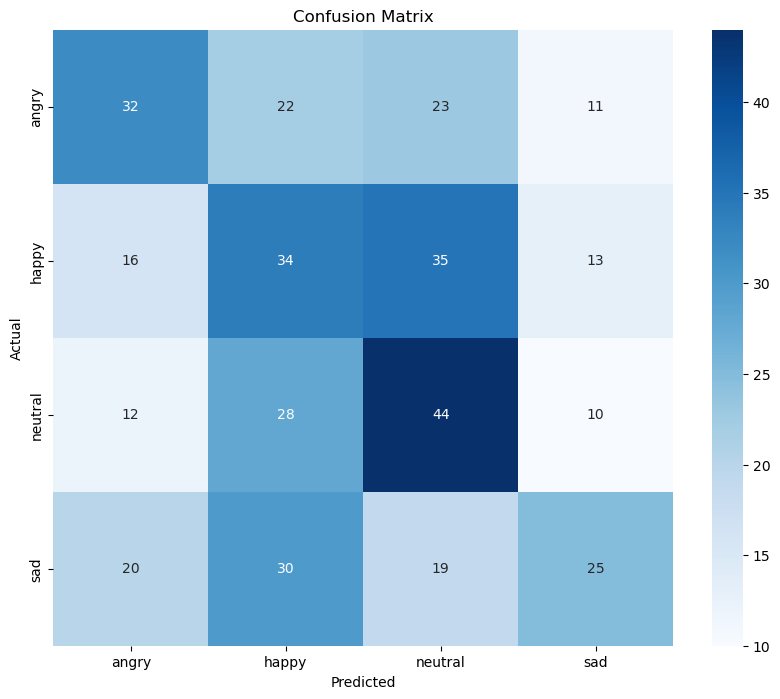

In [20]:
# Evaluate on the training set
evaluate_model(lenet5, train_loader, device, data.classes)

Accuracy: 20.16%
Balanced Accuracy: 19.31%
Macro F1 Score: 0.1961


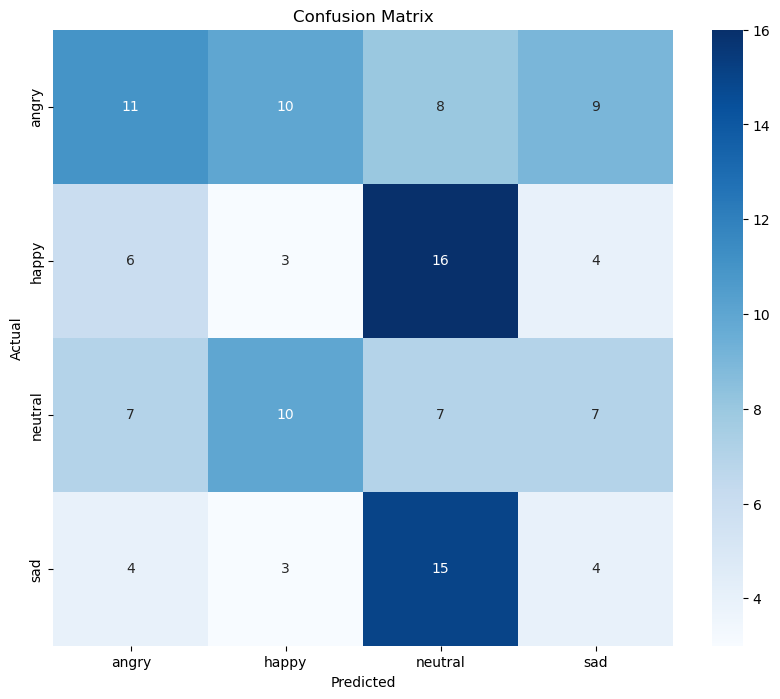

In [21]:
# Evaluate on the val set
evaluate_model(lenet5, val_loader, device, data.classes)

Accuracy: 22.22%
Balanced Accuracy: 22.46%
Macro F1 Score: 0.2145


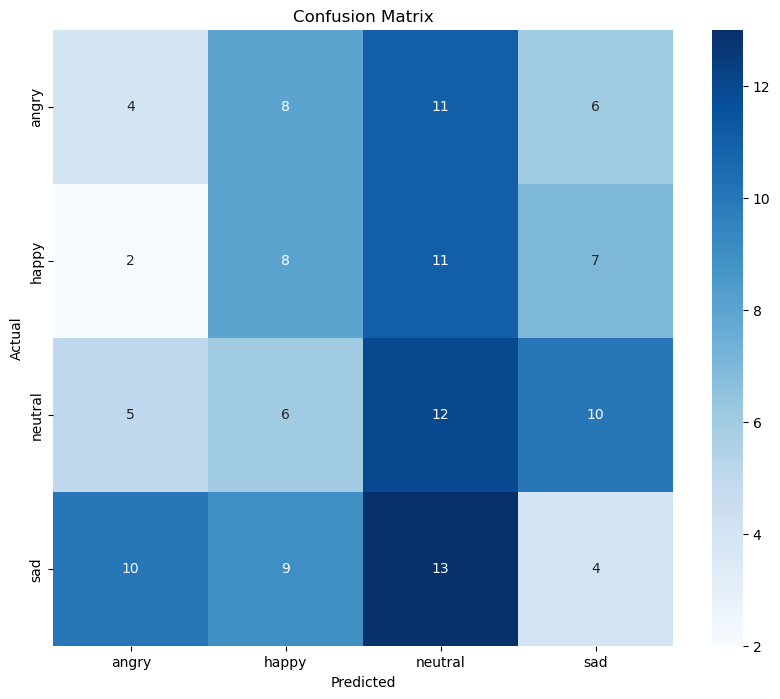

In [22]:
# Evaluate on the test set
evaluate_model(lenet5, test_loader, device, data.classes)

# Getting insights about the results using GradCam

In [23]:
def predict_class(model, image_path, class_names, device, transform):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image)  # Apply the defined transformations
    
    # Add batch dimension (since the model expects batches of images)
    image = image.unsqueeze(0)
    
    # Move the image and model to the appropriate device
    image = image.to(device)
    model = model.to(device)
    
    # Set the model to evaluation mode and make the prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
    
    # Get the predicted class (the class with the highest output score)
    _, predicted_class = torch.max(output, 1)
    
    # Map the predicted class index to the class name
    predicted_class_name = class_names[predicted_class.item()]
    
    return predicted_class_name

In [24]:
def viz_gradcam(image_path, model, class_names, device, transform):
    image = Image.open(image_path)
    image = transform(image).to(device)  #
    
    input_image = image.unsqueeze(0)
    
    predicted_class = predict_class(model, image_path, class_names, device, transform)
    
    # Define target layer for Grad-CAM
    target_layer = model.conv2
    
    # Instantiate Grad-CAM and Grad-CAM++ with the same target layer
    gradcam = GradCAM(model, target_layer)
    gradcam_pp = GradCAMpp(model, target_layer)
    
    # Generate Grad-CAM and Grad-CAM++ masks
    mask, _ = gradcam(input_image)
    mask_pp, _ = gradcam_pp(input_image)
    
    # Visualize the original image and Grad-CAM results
    plt.figure(figsize=(10, 10))
    
    # Original Image
    plt.subplot(1, 4, 1)
    original_image = np.transpose(image.cpu().numpy(), (1, 2, 0))
    original_image = original_image * 0.5 + 0.5  # Reverse normalization
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Pred: {predicted_class}')
    
    # Grad-CAM Heatmap
    heatmap, _ = visualize_cam(mask, image)
    plt.subplot(1, 4, 2)
    plt.imshow(original_image, cmap='gray')
    plt.imshow(np.transpose(heatmap.squeeze().cpu().numpy(), (1, 2, 0)), cmap='jet', alpha=0.5)
    plt.title('Grad-CAM')
    
    # Grad-CAM++ Heatmap
    heatmap_pp, _ = visualize_cam(mask_pp, image)
    plt.subplot(1, 4, 3)
    plt.imshow(original_image, cmap='gray')
    plt.imshow(np.transpose(heatmap_pp.squeeze().cpu().numpy(), (1, 2, 0)), cmap='jet', alpha=0.5)
    plt.title('Grad-CAM++')
    
    # Combined Image with Overlay
    plt.subplot(1, 4, 4)
    combined_image = original_image + np.transpose(heatmap_pp.squeeze().cpu().numpy(), (1, 2, 0))
    combined_image = combined_image / np.max(combined_image)  # Normalize combined image
    plt.imshow(combined_image, cmap='gray')
    plt.title('Overlay')

    plt.show()

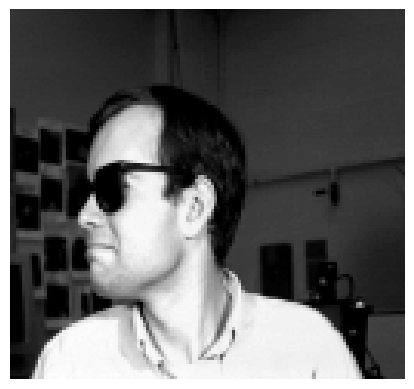

/Users/vivianamarquez/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/Users/vivianamarquez/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/gradcam/gradcam.py:81: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
/Users/vivianamarquez/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/gradcam/gradcam.py:147: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', alig

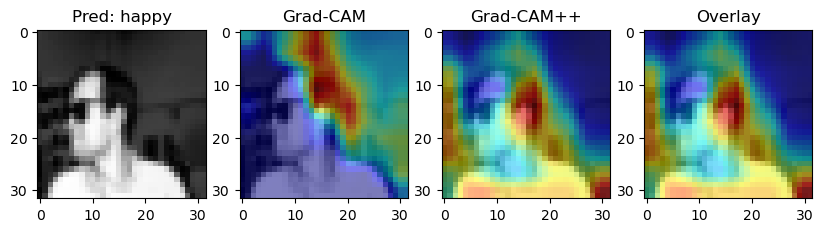

In [25]:
image_path = "../../data/emotions/sad/at33_right_sad_sunglasses.pgm"

display_image = Image.open(image_path)
plt.imshow(display_image, cmap='gray')
plt.axis('off')  
plt.show()

viz_gradcam(image_path, lenet5, class_names, device, transform)

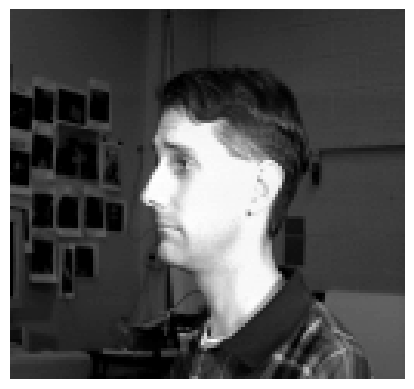

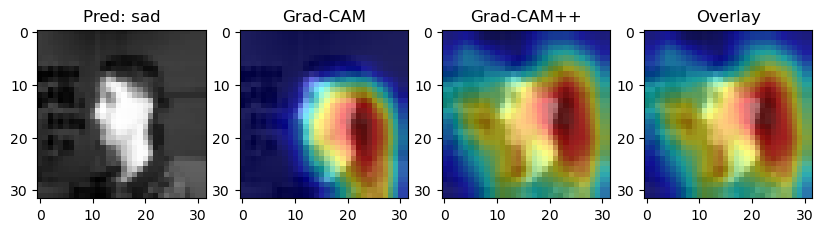

In [26]:
image_path = "../../data/emotions/sad/boland_right_sad_open.pgm"

display_image = Image.open(image_path)
plt.imshow(display_image, cmap='gray')
plt.axis('off')  
plt.show()

viz_gradcam(image_path, lenet5, class_names, device, transform)

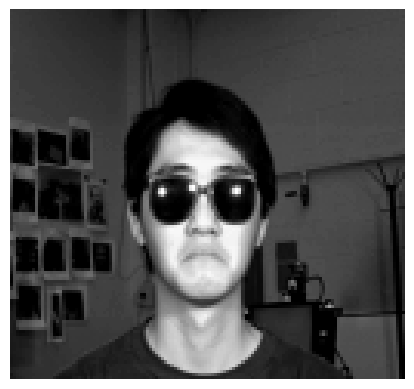

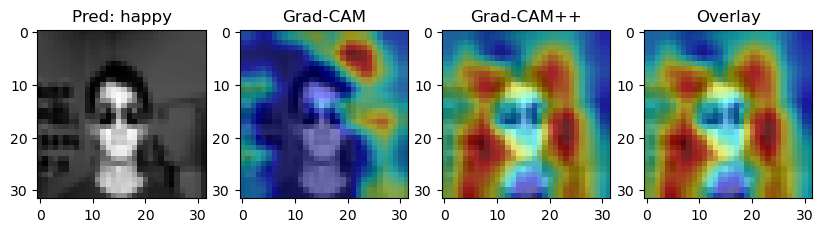

In [27]:
image_path = "../../data/emotions/sad/choon_straight_sad_sunglasses.pgm"

display_image = Image.open(image_path)
plt.imshow(display_image, cmap='gray')
plt.axis('off')  
plt.show()

viz_gradcam(image_path, lenet5, class_names, device, transform)